## Notebook con la actividad balanceado

Es una copia del notebook con la actividad hecha, pero está vez borre registros de la clase naranja para balancear los datos, para ver cuanto mejora el rendimiento


Dataset sacado de: https://github.com/microsoft/ML-For-Beginners/blob/main/2-Regression/data/US-pumpkins.csv

In [343]:
import pandas as pd
import numpy as np
import sklearn


full_pumpkins = pd.read_csv('../data/US-pumpkins.csv')

full_pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [344]:
#Contando valores nulos en cada columna

print(full_pumpkins.shape)
full_pumpkins.isnull().sum()

(1757, 26)


City Name             0
Type               1712
Package               0
Variety               5
Sub Variety        1461
Grade              1757
Date                  0
Low Price             0
High Price            0
Mostly Low          103
Mostly High         103
Origin                3
Origin District    1626
Item Size           279
Color               616
Environment        1757
Unit of Sale       1595
Quality            1757
Condition          1757
Appearance         1757
Storage            1757
Crop               1757
Repack                0
Trans Mode         1757
Unnamed: 24        1757
Unnamed: 25        1654
dtype: int64

In [345]:
#Eliminando las columnas con menos de 1000 valores no-nulos y eliminando los registros nulos en las columnas restantes

clean_pumpkins = full_pumpkins.dropna(axis=1, thresh=1000)
clean_pumpkins = clean_pumpkins.dropna()
clean_pumpkins.head()

,City Name,Package,Variety,Date,Low Price,High Price,Mostly Low,Mostly High,Origin,Item Size,Color,Repack
2,BALTIMORE,24 inch bins,HOWDEN TYPE,9/24/16,160.0,160.0,160.0,160.0,DELAWARE,med,ORANGE,N
3,BALTIMORE,24 inch bins,HOWDEN TYPE,9/24/16,160.0,160.0,160.0,160.0,VIRGINIA,med,ORANGE,N
4,BALTIMORE,24 inch bins,HOWDEN TYPE,11/5/16,90.0,100.0,90.0,100.0,MARYLAND,lge,ORANGE,N
5,BALTIMORE,24 inch bins,HOWDEN TYPE,11/12/16,90.0,100.0,90.0,100.0,MARYLAND,lge,ORANGE,N
6,BALTIMORE,36 inch bins,HOWDEN TYPE,9/24/16,160.0,170.0,160.0,170.0,MARYLAND,med,ORANGE,N


In [346]:
#Creando una nueva columna con el mes en el que se cosecho cada calabaza y quitando las fechas

month = pd.DatetimeIndex(clean_pumpkins['Date']).month
clean_pumpkins['Month'] = month
clean_pumpkins.drop(axis=1, columns='Date', inplace=True)

#Creando una columna con el precio promedio y quitando las columnas con precios altos y bajos

price = (clean_pumpkins['High Price'] + clean_pumpkins['Low Price']) / 2
clean_pumpkins['Price'] = price
clean_pumpkins.drop(axis=1, columns=['High Price', 'Low Price', "Mostly Low", "Mostly High"], inplace=True)

In [347]:
#Viendo los valores unicos de las columnas no-numericas 

for column in clean_pumpkins.columns.difference(['Price', 'Month']):
    print(clean_pumpkins[column].value_counts())


City Name
BOSTON           348
COLUMBIA         173
CHICAGO           87
BALTIMORE         80
DALLAS            60
NEW YORK          58
ATLANTA           35
SAN FRANCISCO     34
PHILADELPHIA      28
LOS ANGELES       26
DETROIT           15
MIAMI              2
Name: count, dtype: int64
Color
ORANGE    795
WHITE     151
Name: count, dtype: int64
Item Size
sml        273
lge        182
xlge       146
med        136
med-lge    100
jbo         97
exjbo       12
Name: count, dtype: int64
Origin
MASSACHUSETTS     194
PENNSYLVANIA      180
MICHIGAN          132
CANADA             70
CALIFORNIA         60
TEXAS              54
MARYLAND           49
OHIO               45
VIRGINIA           43
ILLINOIS           28
NORTH CAROLINA     27
NEW JERSEY         20
NEW YORK           16
DELAWARE           11
VERMONT             6
MEXICO              6
ALABAMA             4
TENNESSEE           1
Name: count, dtype: int64
Package
36 inch bins            490
24 inch bins            268
1/2 bushel cartons

In [348]:
#Quitando la columna Repack ya que todos los registros tienen el mismo valor

clean_pumpkins.drop(axis=1, columns='Repack', inplace=True)


In [349]:
#Se quita la unica fila con el tipo "bins" ya que faltan detalles y ademas es una categoria con un solo dato
clean_pumpkins = clean_pumpkins[clean_pumpkins['Package'] != 'bins']

#Las bushel crates y los bushel cartons tienen el mismo volumen. La diferencia solo esta en la forma y el material de la caja. Por lo que
#se las convierte en una sola categoria
clean_pumpkins.loc[clean_pumpkins['Package'] == '1 1/9 bushel crates', 'Package'] = '1 1/9 bushel cartons'

#Estandarizando precios para que queden en bushel cartons, segun estimaciones de ChatGPT
clean_pumpkins.loc[clean_pumpkins['Package'] == '36 inch bins', 'Price'] = clean_pumpkins['Price'] / 7.23
clean_pumpkins.loc[clean_pumpkins['Package'] == '24 inch bins', 'Price'] = clean_pumpkins['Price'] / 2.41
clean_pumpkins.loc[clean_pumpkins['Package'] == '1 1/9 bushel cartons', 'Price'] = clean_pumpkins['Price'] / (10/9)
clean_pumpkins.loc[clean_pumpkins['Package'] == '1/2 bushel cartons', 'Price'] = clean_pumpkins['Price'] / 0.5

clean_pumpkins.head()

,City Name,Package,Variety,Origin,Item Size,Color,Month,Price
2,BALTIMORE,24 inch bins,HOWDEN TYPE,DELAWARE,med,ORANGE,9,66.390041
3,BALTIMORE,24 inch bins,HOWDEN TYPE,VIRGINIA,med,ORANGE,9,66.390041
4,BALTIMORE,24 inch bins,HOWDEN TYPE,MARYLAND,lge,ORANGE,11,39.419087
5,BALTIMORE,24 inch bins,HOWDEN TYPE,MARYLAND,lge,ORANGE,11,39.419087
6,BALTIMORE,36 inch bins,HOWDEN TYPE,MARYLAND,med,ORANGE,9,22.821577


In [350]:
#Codificando la columnas ordinales Package y Item Size
from sklearn.preprocessing import OrdinalEncoder
item_size_categories = ['sml', 'med', 'med-lge', 'lge', 'xlge', 'jbo', 'exjbo']
item_package_categories = ["36 inch bins", "24 inch bins", "1 1/9 bushel cartons", "bushel cartons", "1/2 bushel cartons"]

ordinal_features = ['Package', 'Item Size']

ordinal_encoder = OrdinalEncoder(categories=[item_package_categories, item_size_categories])

In [351]:
#Codificando el resto de columnas categoricas con un OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

onehot_features = clean_pumpkins.drop(axis=1, columns=ordinal_features + ['Price', 'Month', "Color"]).columns # type: ignore

onehot_encoder = OneHotEncoder(sparse_output=False)

In [352]:
#Utilizando ColumnTransformer para combinar varios codificadores en un solo paso y aplicarlos a las columnas correspondientes
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    transformers=[
        ('oneh', onehot_encoder, onehot_features),
        ('ord', ordinal_encoder, ordinal_features)
    ]
)

ct.set_output(transform='pandas')
encoded_features = ct.fit_transform(clean_pumpkins)
encoded_features.head()

,oneh__City Name_ATLANTA,oneh__City Name_BALTIMORE,oneh__City Name_BOSTON,oneh__City Name_CHICAGO,oneh__City Name_COLUMBIA,oneh__City Name_DALLAS,oneh__City Name_DETROIT,oneh__City Name_LOS ANGELES,oneh__City Name_MIAMI,oneh__City Name_NEW YORK,...,oneh__Origin_NEW YORK,oneh__Origin_NORTH CAROLINA,oneh__Origin_OHIO,oneh__Origin_PENNSYLVANIA,oneh__Origin_TENNESSEE,oneh__Origin_TEXAS,oneh__Origin_VERMONT,oneh__Origin_VIRGINIA,ord__Package,ord__Item Size
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [353]:
#Utilizando LabelEncoder para normalizar las etiquetas, de tal forma que estas solo contengan valores entre 0 y n_labels-1
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(clean_pumpkins['Color'])

In [354]:
#Seleccionando variables y dividiendo datos
from sklearn.model_selection import train_test_split

X = encoded_features
y = encoded_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#Creando y entrenando modelo
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

#Imprimiendo metricas y predicciónes
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_test, predictions))
print('Predicted labels: ', predictions)
print('F1-score: ', f1_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       164
           1       0.77      0.96      0.86        25

    accuracy                           0.96       189
   macro avg       0.88      0.96      0.92       189
weighted avg       0.96      0.96      0.96       189

Predicted labels:  [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0
 0 0 0 0]
F1-score:  0.8571428571428571


<Axes: >

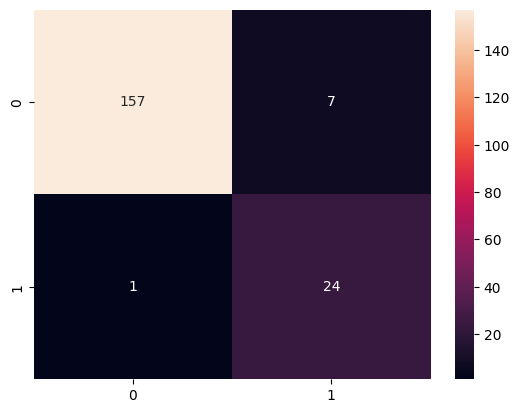

In [355]:
#Calculando matriz de confusion y graficandola con un heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d")

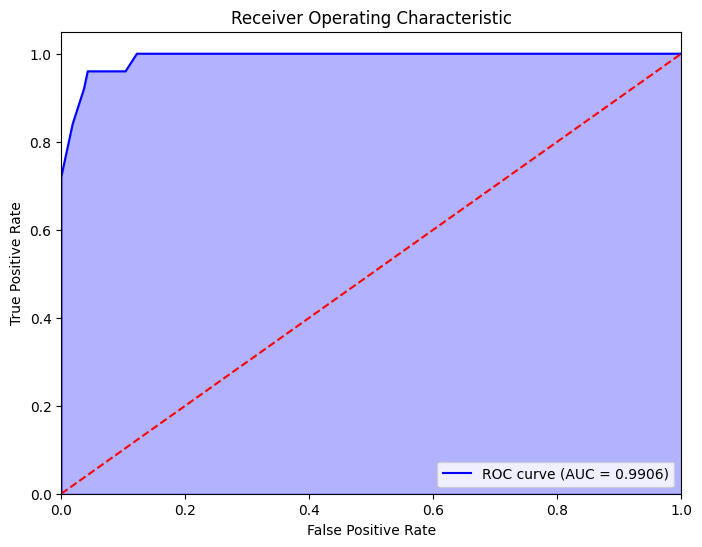

In [356]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc = roc_auc_score(y_test, y_pred_prob)

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Resaltar el AUC
plt.fill_between(fpr, tpr, alpha=0.3, color='blue')

# Mostrar el gráfico
plt.show()
